In [145]:
import pandas as pd
from collections import Counter

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from matplotlib import pyplot as plt
import numpy as np
import os
import re


In [135]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [136]:
#removing bulshit that may interfere with sequencing
train.text = train.text.replace(to_replace=r'[\?0-9#\'.@:\[\],]', value=' ', regex=True)

In [137]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train.text)
sequences = tokenizer.texts_to_sequences(train.text)

In [138]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22508 unique tokens.


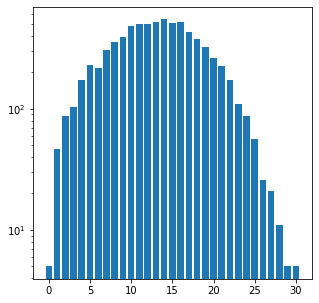

,0
count,7613.000000
mean,13.246421
std,5.375394
min,0.000000
25%,9.000000
50%,13.000000
75%,17.000000
max,30.000000


In [141]:
lengths=Counter([int(len(i)) for i in sequences])
plt.figure(figsize=(5,5))
plt.bar(lengths.keys(),lengths.values(),log=True)
plt.show()
pd.DataFrame([int(len(i)) for i in sequences]).describe()

In [139]:
data = pad_sequences(sequences, maxlen=30)
labels = to_categorical(np.asarray(train.target))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (7613, 30)
Shape of label tensor: (7613, 2)


In [211]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(.3 * data.shape[0])


In [212]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [213]:
embeddings_index = {}
f = open(os.path.join('/Users/fariszahrah/Data/glove.twitter.27B/', 'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1193514 word vectors.


In [214]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [222]:
from keras.layers import Embedding, Flatten, Dense, Conv1D, MaxPooling1D
from keras.models import Model, Input

embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=30,
                            trainable=False)

sequence_input = Input(shape=(30,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(256, 7, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Conv1D(16, 5, activation='relu')(x)
x = MaxPooling1D(4)(x)
#x = Conv1D(128, 1, activation='relu')(x)
#x = MaxPooling1D(1)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(labels.shape[1], activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc']
             )

In [223]:
# happy learning!
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=16)

Train on 5330 samples, validate on 2283 samples
Epoch 1/10
5330/5330 [==============================] - 2s 384us/step - loss: 0.4997 - acc: 0.7629 - val_loss: 0.5340 - val_acc: 0.7762
Epoch 2/10
5330/5330 [==============================] - 2s 332us/step - loss: 0.4111 - acc: 0.8152 - val_loss: 0.4853 - val_acc: 0.7858
Epoch 3/10
5330/5330 [==============================] - 2s 333us/step - loss: 0.3189 - acc: 0.8675 - val_loss: 0.8129 - val_acc: 0.6899
Epoch 4/10
5330/5330 [==============================] - 2s 336us/step - loss: 0.2356 - acc: 0.9129 - val_loss: 0.5884 - val_acc: 0.7972
Epoch 5/10
5330/5330 [==============================] - 2s 343us/step - loss: 0.1786 - acc: 0.9405 - val_loss: 0.7382 - val_acc: 0.7775
Epoch 6/10
5330/5330 [==============================] - 2s 335us/step - loss: 0.1343 - acc: 0.9567 - val_loss: 0.7419 - val_acc: 0.7933
Epoch 7/10
5330/5330 [==============================] - 2s 339us/step - loss: 0.1211 - acc: 0.9617 - val_loss: 0.8814 - val_acc: 0.7801
